
# Семинар 8: "Снижение размерности"

Хапкин Артем Владимирович

In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline

/home/temkahap/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [2]:
X = fetch_olivetti_faces()['data']

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/temkahap/scikit_learn_data


In [21]:
X.shape

(400, 4096)

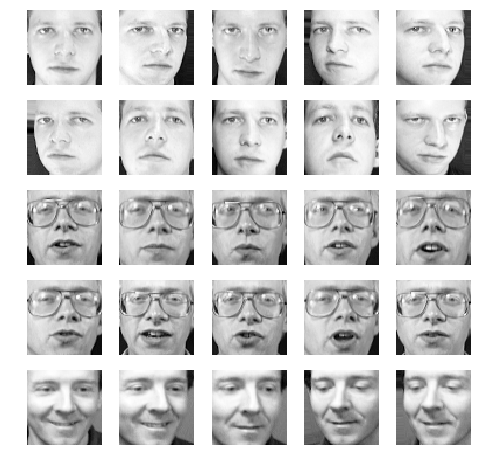

In [4]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

# Часть 1: PCA

In [126]:
from sklearn.decomposition import PCA
import math

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

Подсказка: используйте метод <b>.components_</b>

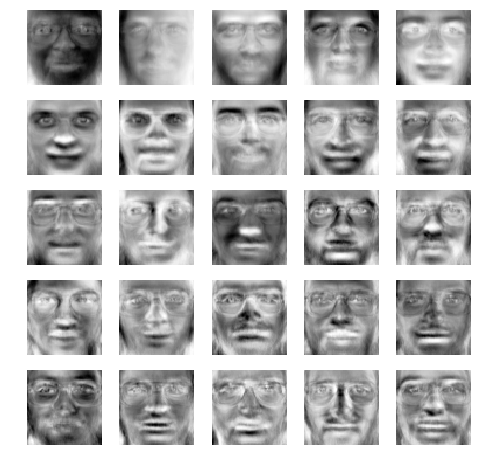

In [154]:
N_COMPONENTS = 25
model = PCA(n_components=N_COMPONENTS)
model.fit(X)
data_principle = model.components_
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(data_principle[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

In [142]:
model = PCA(n_components=N_COMPONENTS)
data = model.fit_transform(X)
reconstructions = model.inverse_transform(data)

In [143]:
print (data.shape, reconstructions.shape)


(400, 25) (400, 4096)


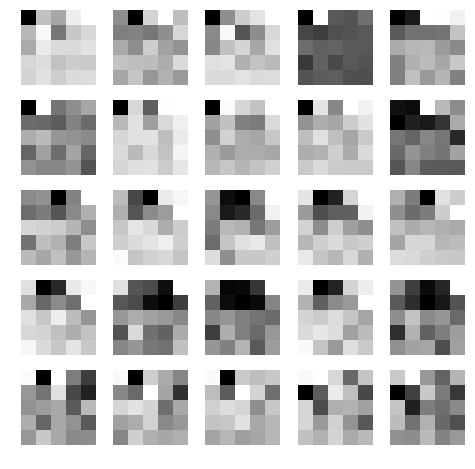

In [144]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(data[i].reshape(int(math.sqrt(N_COMPONENTS)), int(math.sqrt(N_COMPONENTS))), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

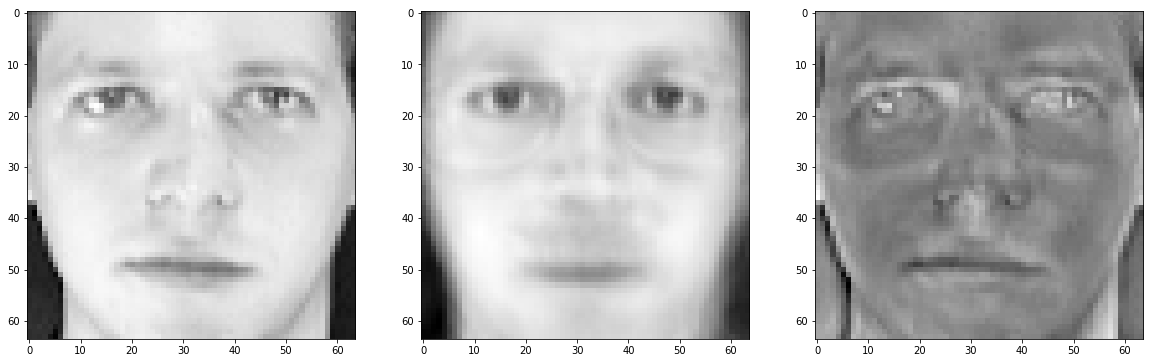

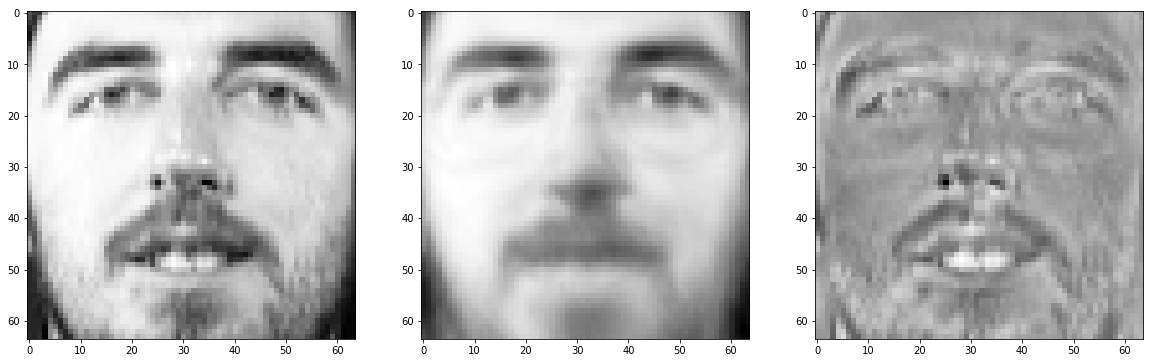

In [145]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(X[0].reshape((64, 64)), cmap=plt.cm.Greys_r)
plt.subplot(1, 3, 2)
plt.imshow(reconstructions[0].reshape((64, 64)), cmap=plt.cm.Greys_r)
plt.subplot(1, 3, 3)
plt.imshow((X - reconstructions)[0].reshape((64, 64)), cmap=plt.cm.Greys_r)

plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(X[100].reshape((64, 64)), cmap=plt.cm.Greys_r)
plt.subplot(1, 3, 2)
plt.imshow(reconstructions[100].reshape((64, 64)), cmap=plt.cm.Greys_r)
plt.subplot(1, 3, 3)
plt.imshow((X - reconstructions)[100].reshape((64, 64)), cmap=plt.cm.Greys_r)

 1.2 Отобразите зависимость качества восстановления от количества компонент

Подсказка: используйте методы .explained_variance_ratio_ и np.cumsum()


Если смотреть на глаз и использвать метод локтя, то 25 компонент - вроде норм получается.


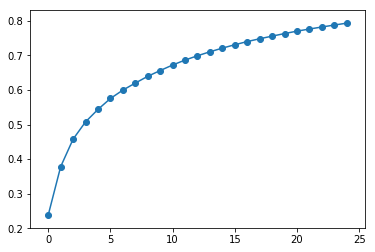

In [146]:
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.scatter( range(25), np.cumsum(model.explained_variance_ratio_))
print ("Если смотреть на глаз и использвать метод локтя, то 25 компонент - вроде норм получается.")

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

In [147]:
def test_pca(n_comp):
    model = PCA(n_components=n_comp)
    data = model.fit_transform(X)
    reconstructions = model.inverse_transform(data)
    return ((reconstructions - X)**2).sum() / X.shape[0]

In [148]:
errors = []
components = range(1, 125)

for n_comp in components:
    errors.append(test_pca(n_comp))

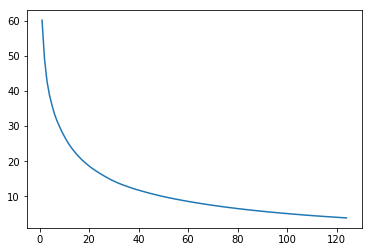

In [149]:
plt.plot(components, errors)

1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют? Чему соответствуют главные компоненты?


In [122]:
# Код для отображения изображений в 2D
def plot_dataset(X, emb, margin=50, frame=2000., imsize=64):
    assert(emb.shape[1] == 2)
    emb = np.array((emb - emb.min(0)) * (frame / (emb.max(0) - emb.min(0))) + margin, dtype = np.int)
    image = np.zeros((int(emb[:, 0].max() + margin + imsize), int(emb[:, 1].max() + margin + imsize))) + 1
    for k in range(X.shape[0]):
        image[emb[k, 0]:emb[k, 0]+64, emb[k, 1]:emb[k, 1]+64] = X[k].reshape(64, 64)
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("off")
    plt.show()

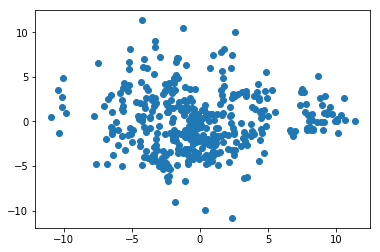

In [123]:
model = PCA(n_components=2)
data = model.fit_transform(X)
plt.scatter(data[:,0], data[:,1])

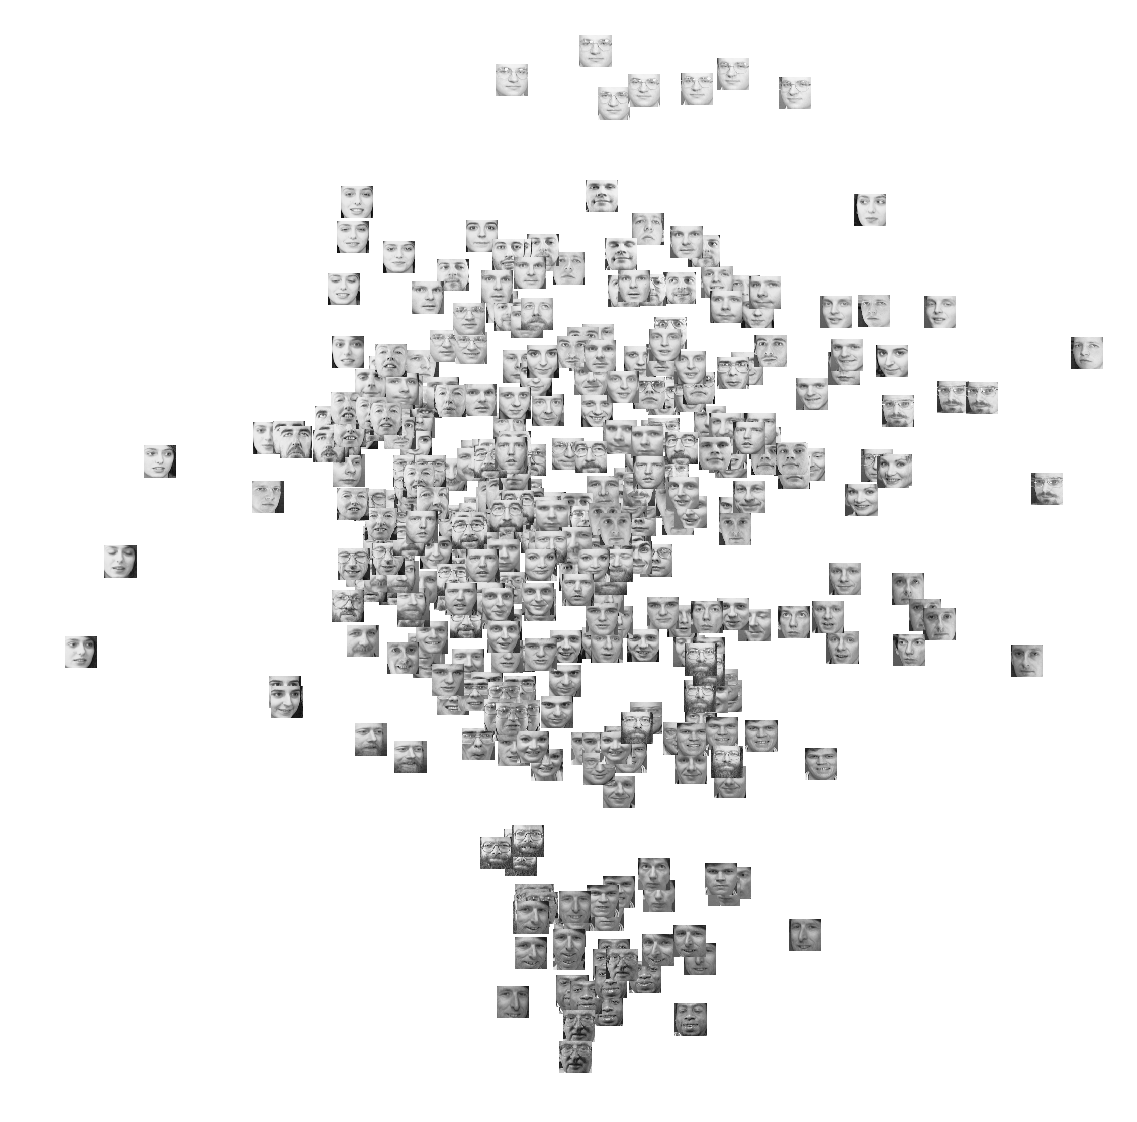

In [124]:
plot_dataset(X, data)


#  Часть 2: Автокодировщик

In [155]:
from torch.utils.data import DataLoader, Dataset


In [158]:
class FaceDataset(Dataset):
    def __init__(self, X, transform=None):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

In [160]:
dataset = FaceDataset(X)
dataloader = DataLoader(dataset, batch_size=16, shuffle = True)


In [161]:
def fully_connected(arc, last_nonlinearity=True):
    layers = []
    for i in range(len(arc)-1):
        layers.append(nn.Linear(arc[i], arc[i+1]))
        if i != len(arc)-2 or last_nonlinearity:
            layers.append(nn.LeakyReLU())
    return nn.Sequential(*layers)


In [162]:
class AE(nn.Module):
    def __init__(self, arc_encoder, arc_decoder):
        super(AE, self).__init__()
        
        self.encoder = fully_connected(arc_encoder)
        self.decoder = fully_connected(arc_decoder)
        
    def forward(self, X):
        return self.decoder(self.encoder(X))

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

In [164]:
fully_connected([4096, 200, 10], last_nonlinearity=False)
model = AE([4096, 200, 10], [10,200,4096])
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [167]:
loss_final = []
for epoch in range(100):
    losses = []
    for x in dataloader:
        x_batch = Variable(x, requires_grad=True)
        y_batch = Variable(x, requires_grad=False)
        model.zero_grad()
        x_preconstruct = model(x_batch)
        loss_batch = loss(x_preconstruct, y_batch)
        loss_batch.backward()
        optimizer.step()
        losses.append(loss_batch.data[0])
    loss_final.append(np.mean(losses))
    if (epoch % 5 == 0):
        print (epoch, np.mean(losses))

0 0.00841720882803
5 0.00829607803375
10 0.00992648540065
15 0.00806383522227
20 0.00808835143223
25 0.00779435414821
30 0.00778372317553
35 0.0082380746305
40 0.00743190273643
45 0.00738926045597
50 0.00710182731971
55 0.00714178279042
60 0.00681709159166
65 0.00686295699328
70 0.00664229745045
75 0.00659656567499
80 0.00655224833637
85 0.00652007292956
90 0.00644867813215
95 0.00665663544089


<i> 2.2 Какое качество восстановления удалось получить?</i>

In [169]:
emb = model.encoder(Variable(torch.Tensor(X))).data.numpy()
reconstr = model(Variable(torch.Tensor(X))).data.numpy()



(400, 10)

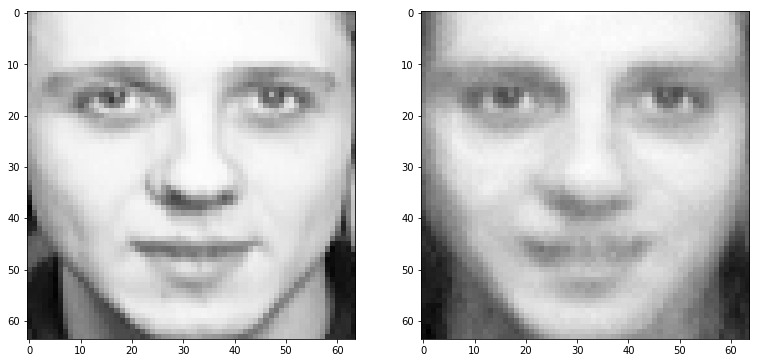

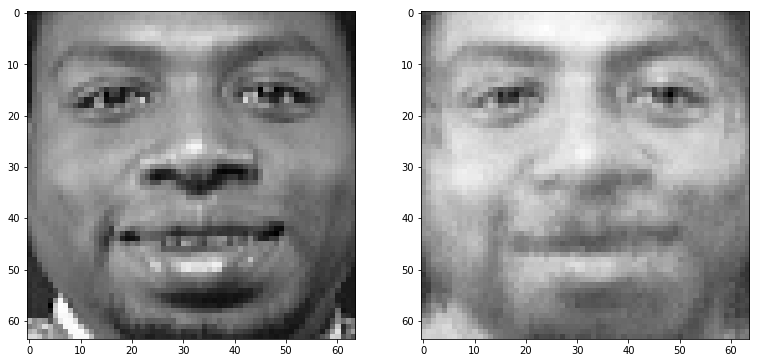

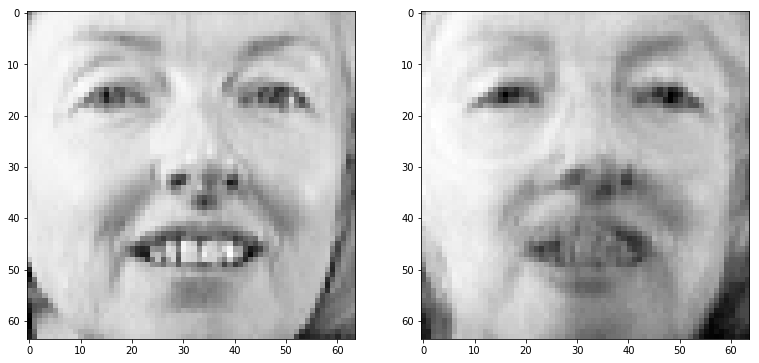

In [173]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(X[110].reshape((64, 64)), cmap=plt.cm.Greys_r)
plt.subplot(1, 3, 2)
plt.imshow(reconstr[110].reshape((64, 64)), cmap=plt.cm.Greys_r)

plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(X[210].reshape((64, 64)), cmap=plt.cm.Greys_r)
plt.subplot(1, 3, 2)
plt.imshow(reconstr[210].reshape((64, 64)), cmap=plt.cm.Greys_r)

plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(X[310].reshape((64, 64)), cmap=plt.cm.Greys_r)
plt.subplot(1, 3, 2)
plt.imshow(reconstr[310].reshape((64, 64)), cmap=plt.cm.Greys_r)

<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

In [179]:
def AE_train(model):
    for epoch in range(30):
        losses = []
        for x in dataloader:
            x_batch = Variable(x, requires_grad=True)
            y_batch = Variable(x, requires_grad=False)
            model.zero_grad()
            x_preconstruct = model(x_batch)
            loss_batch = loss(x_preconstruct, y_batch)
            loss_batch.backward()
            optimizer.step()
            losses.append(loss_batch.data[0])
            
    reconstr = model(Variable(torch.Tensor(X))).data.numpy()
    return ((reconstr - X) ** 2).sum() / X.shape[0]

In [180]:
errors = []
components = range(5, 30)

for n_comp in components:
    glob_losses = []
    
    model = AE((4096, 200, n_comp), [n_comp, 100, 4096])
    loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    temp_error = AE_train(model)
    errors.append(temp_error)
    print (temp_error)



52.1847460938
61.6974462891
61.5702832031
61.9823486328
51.0337841797
39.7307910156
37.1068164062
37.2818139648
35.3061499023
33.9937304688
36.5040917969
38.3918774414
40.5467211914
42.98
34.6545996094
35.0205029297
35.9980444336
35.7647509766
33.8885131836
33.1505175781
34.0438256836
31.15546875
34.0339233398
31.9772485352
34.8161523437


<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

In [196]:
#Вроде норм получается, хоть и не запускал до 120 компонент, как в Pca, но тренд прослеживается
#Есть мысль, что если бы запустил на 120 компонентах, то возможно не было
#бы сходимости дальше, но это скорее всего решалось бы увеличением числа эпох в обучении сети

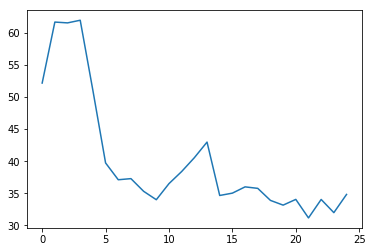

In [197]:
plt.plot(errors)

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [190]:
fully_connected([4096, 200, 10], last_nonlinearity=False)
model = AE([4096, 200, 2], [2,200,4096])
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

loss_final = []
for epoch in range(100):
    losses = []
    for x in dataloader:
        x_batch = Variable(x, requires_grad=True)
        y_batch = Variable(x, requires_grad=False)
        model.zero_grad()
        x_preconstruct = model(x_batch)
        loss_batch = loss(x_preconstruct, y_batch)
        loss_batch.backward()
        optimizer.step()
        losses.append(loss_batch.data[0])
    loss_final.append(np.mean(losses))
    if (epoch % 5 == 0):
        print (epoch, np.mean(losses))

0 0.121889746189
5 0.0174429157749
10 0.0154491072521
15 0.0150765187293
20 0.0146436863393
25 0.0124758284166
30 0.0122612724081
35 0.0120947010443
40 0.0119986524805
45 0.0119700035453
50 0.0119426490366
55 0.0118764098361
60 0.0118348241597
65 0.011789525114
70 0.0116586848348
75 0.0137703122944
80 0.0117916895449
85 0.0116276900843
90 0.0115437359363
95 0.011554572992


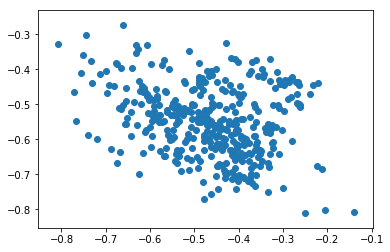

In [192]:
emb = model.encoder(Variable(torch.Tensor(X))).data.numpy()
x_0 = emb[:,0]
x_1 = emb[:,1]
plt.scatter(x_0, x_1)

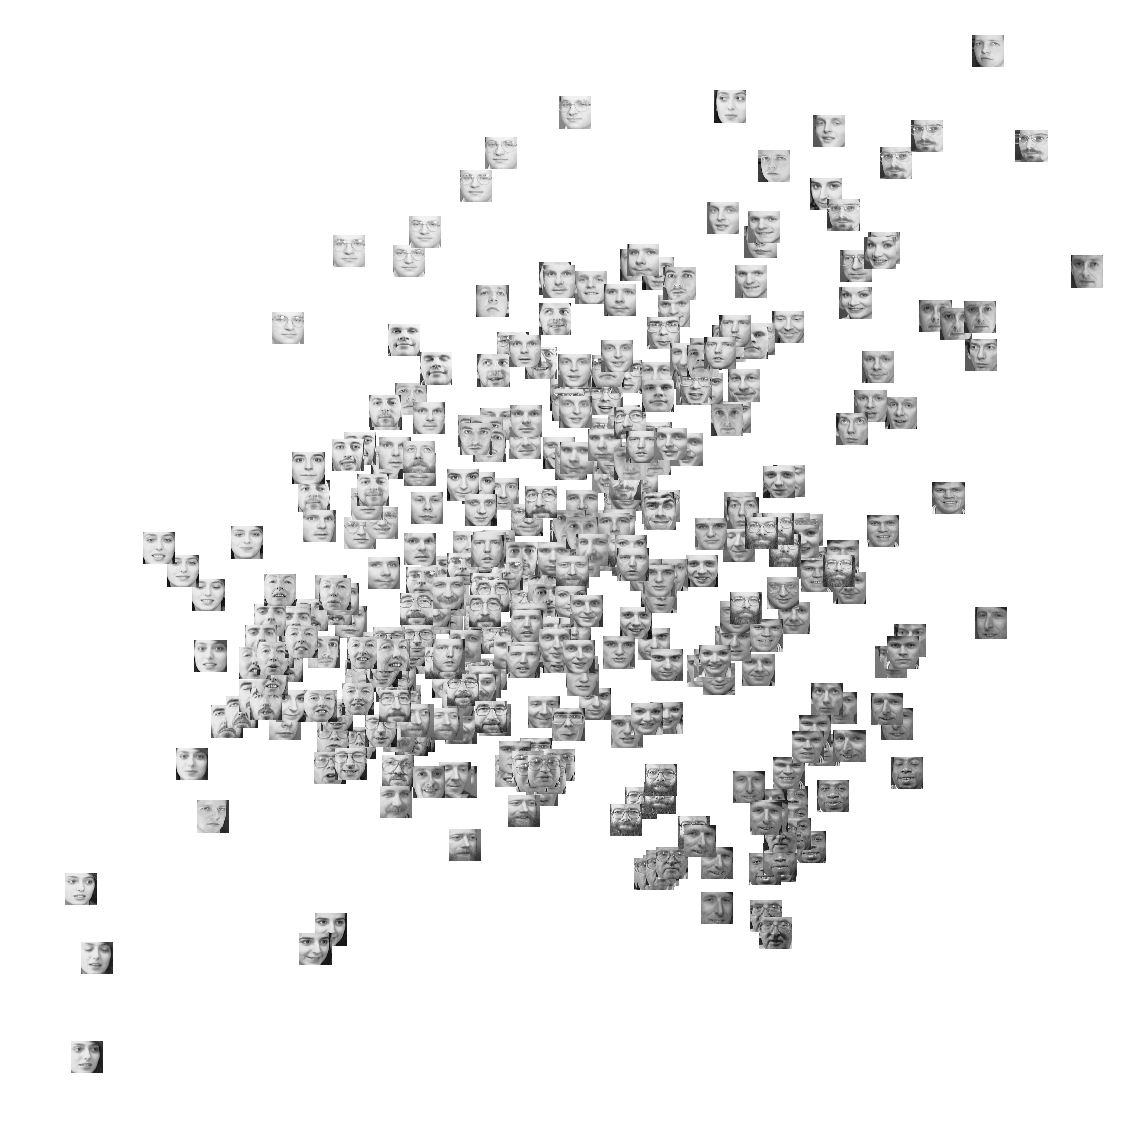

In [195]:
#Получилось похоже на обычный PCA.
plot_dataset(X, emb)